In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geojson
import geopandas as gpd

from shapely.geometry import Polygon, Point
from scipy.spatial import Voronoi, voronoi_plot_2d
from itertools import combinations
from tqdm import tqdm
from pathlib import Path
from pprint import pprint, pformat
from IPython.display import display

In [3]:
# my own defined helper function
from src.plot_geo import (scatter_by_fixed_area,
                          plot_cluster_centroid,
                          plot_voronoi_plot_2d,
                          plot_voronoi_with_bound,
                          DEFAULT_GEO_ARGS)
print('-'*87)
print(f"""
DEFAULT_GEO_ARGS =
{pformat(DEFAULT_GEO_ARGS)}
""")

from src.algorithm import (get_hdbscan_cluster_label,
                           get_centroid,
                           get_voronoi_polygon,
                           map_points_in_polygon,
                           get_bounded_polygon)

---------------------------------------------------------------------------------------

DEFAULT_GEO_ARGS =
{'lat_bound': (24.95, 25.15),
 'lat_granularity': 0.02,
 'lng_bound': (121.44, 121.64),
 'lng_granularity': 0.02}



In [4]:
# my own defined global variable
FILE_BOUNDARY_POLYGON = 'data/TOWN_MOI_1080726.shp'
TARGET_COUNTY = '臺北市'
TARGET_TOWN = '大安區'
SAVE_DIR = 'demo'

if not Path(SAVE_DIR).exists():
    Path(SAVE_DIR).mkdir(parents=True)

NUM_SAMPLES = 10000

# File IO

---

## Data Input

This process required two kinds of data

- geo sample: based on sample density will apply to cluster
- boundary polygon: required boundary to limit the infinite polygon generate by Voronoi

In [5]:
# read the boundary polygon
gdf_boundary = gpd.read_file(FILE_BOUNDARY_POLYGON, encoding='utf8')

# extract a small polygon as the demo target
gdf_boundary = gdf_boundary.loc[(gdf_boundary.COUNTYNAME == TARGET_COUNTY) & \
                                (gdf_boundary.TOWNNAME == TARGET_TOWN)].reset_index(drop=True)
boundary_geom = gdf_boundary.loc[0, 'geometry']
print(f'Extract the {TARGET_COUNTY}.{TARGET_TOWN} polygon as boundary ({type(boundary_geom)})')

Extract the 臺北市.大安區 polygon as boundary (<class 'shapely.geometry.polygon.Polygon'>)


## Data Preprocess

Note: We use `numpy` to generate the random sample and read the City Polygon from the open data website [link](https://data.gov.tw/dataset/7441) as boundary.

- generate multinormal distribution samples
- filter the points out of polygon
- plot the sample to check the sample distribution (`scatter_by_fixed_area` is my own helper function)

In [6]:
# generate the sample data based on polygon
min_lng, min_lat, max_lng, max_lat = boundary_geom.bounds
sample_lng, sample_lat = np.random.multivariate_normal(
    mean=[min_lng+(max_lng-min_lng)/2, min_lat+(max_lat-min_lat)/2],
    cov=[[1e-4, 0], [0, 1e-4]],
    size=NUM_SAMPLES
).T

# create the geometry dataframe and filter the points out of boundary
gdf_sample = gpd.GeoDataFrame({
    'lng': sample_lng,
    'lat': sample_lat,
})
gdf_sample['in_polygon'] = gdf_sample.apply(
    lambda row: Point(row['lng'], row['lat']).within(boundary_geom),
    axis=1)
gdf_sample_clean = gdf_sample.loc[gdf_sample['in_polygon']]
print(f"""
Polygon bounds in {boundary_geom.bounds}

- Generate {NUM_SAMPLES} samples by the polygon bound, shape = {gdf_sample.shape}
- Clean the sample point out of the polygon, shape = {gdf_sample_clean.shape}
""")
display(gdf_sample.head())


Polygon bounds in (121.52168228900007, 25.00776336100006, 121.5659426850001, 25.04546498900004)

- Generate 10000 samples by the polygon bound, shape = (10000, 3)
- Clean the sample point out of the polygon, shape = (7701, 3)



,lng,lat,in_polygon
0,121.560438,25.026593,False
1,121.538926,25.014811,True
2,121.549824,25.037099,True
3,121.545378,25.025218,True
4,121.558508,25.024473,False


/home/afun/github/projects/geo-separation/src/plot_geo.py:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


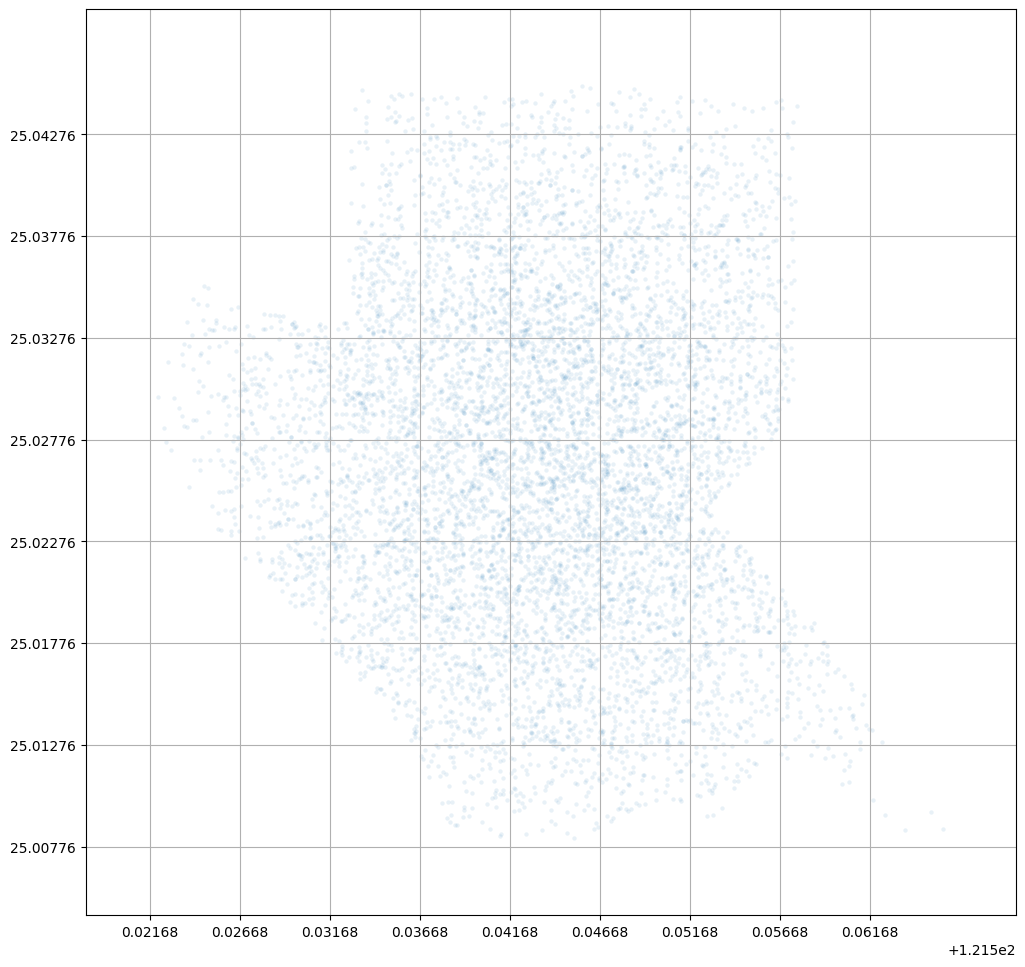

In [7]:
fig_sample = scatter_by_fixed_area(gdf_sample_clean.lng, gdf_sample_clean.lat,
                                   lng_bound=(min_lng, max_lng),
                                   lat_bound=(min_lat, max_lat),
                                   lng_granularity=0.005,
                                   lat_granularity=0.005)
plt.savefig(str(Path(SAVE_DIR) / f'{TARGET_COUNTY}_{TARGET_TOWN}_sample.png'))
plt.show()

# Algorithm

---

## Clustering

We choose `HDBSCAN` as out clustering algoithm.

- choose the min_cluster_size to fit the data

Note: if you want to keep the local partial behavior, recommand to downsample by grid

In [8]:
# cluster
gdf_sample_clean['cluster_label'] = get_hdbscan_cluster_label(gdf_sample_clean[['lat', 'lng']].values,
                                                              min_cluster_size=8)
# get cluster centroid as the voronoi input
coor_centroid = get_centroid(gdf_sample_clean[['lat', 'lng']].values,
                             gdf_sample_clean['cluster_label'].values)
print(f"""
Number of {NUM_SAMPLES} samples generate {len(np.unique(gdf_sample_clean['cluster_label'].values))} clustering
""")


Number of 10000 samples generate 5 clustering



/home/afun/.local/share/virtualenvs/geo-separation--Pjb37o3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


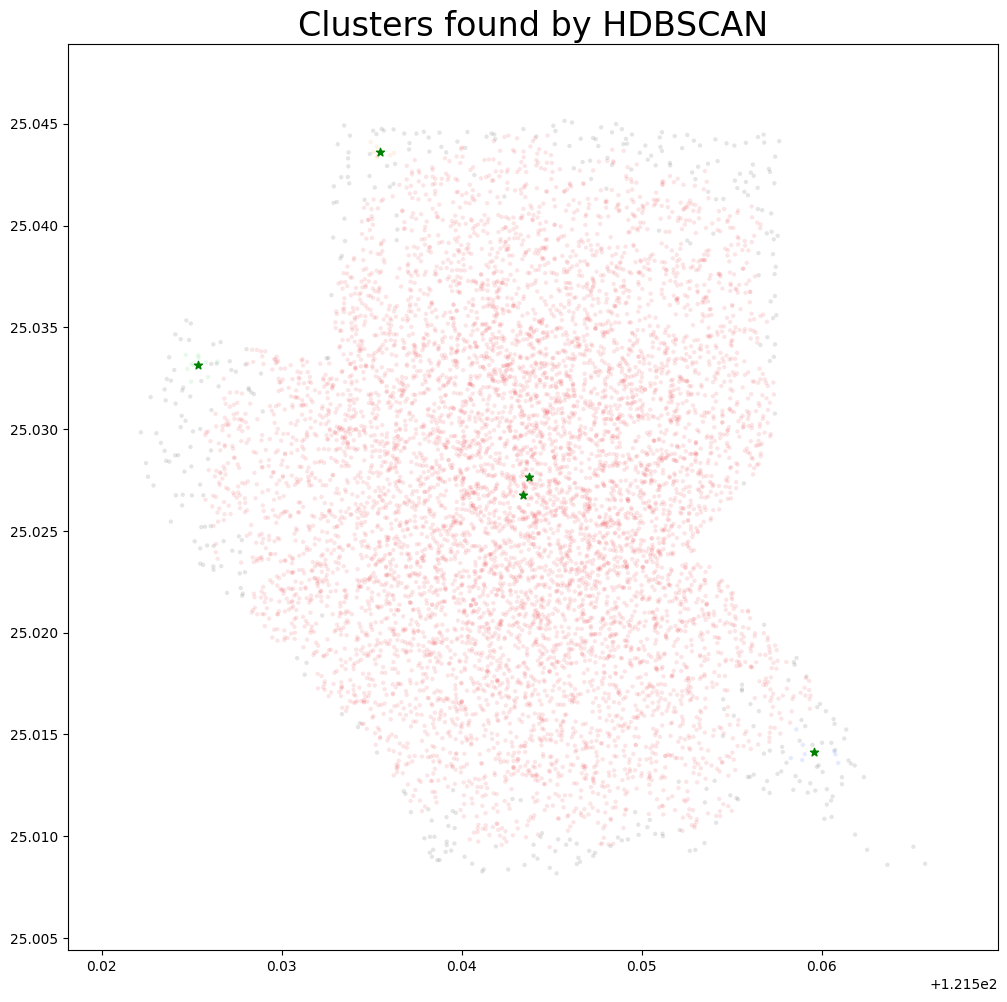

In [9]:
fig_centroid = plot_cluster_centroid(gdf_sample_clean[['lat', 'lng']].values,
                                     gdf_sample_clean['cluster_label'].values,
                                     coor_centroid)
plt.savefig(str(Path(SAVE_DIR) / f'{TARGET_COUNTY}_{TARGET_TOWN}_hdbscan.png'))
plt.show()

## Voronoi

> voronoi polygon: http://zderadicka.eu/voronoi-diagrams/

Use the cluster centroid as the voronoi input to get the spatial seperation polygon

**Vor attribute**

- points    (ndarray of double, shape (npoints, ndim)) Coordinates of input points.
- vertices    (ndarray of double, shape (nvertices, ndim)) Coordinates of the Voronoi vertices.
- ridge_points    (ndarray of ints, shape (nridges, 2)) Indices of the points between which each Voronoi ridge lies.
- ridge_vertices    (list of list of ints, shape (nridges, *)) Indices of the Voronoi vertices forming each Voronoi ridge.
- regions    (list of list of ints, shape (nregions, *)) Indices of the Voronoi vertices forming each Voronoi region. -1 indicates vertex outside the Voronoi diagram.
- point_region    (list of ints, shape (npoints)) Index of the Voronoi region for each input point. If qhull option “Qc” was not specified, the list will contain -1 for points that are not associated with a Voronoi region.

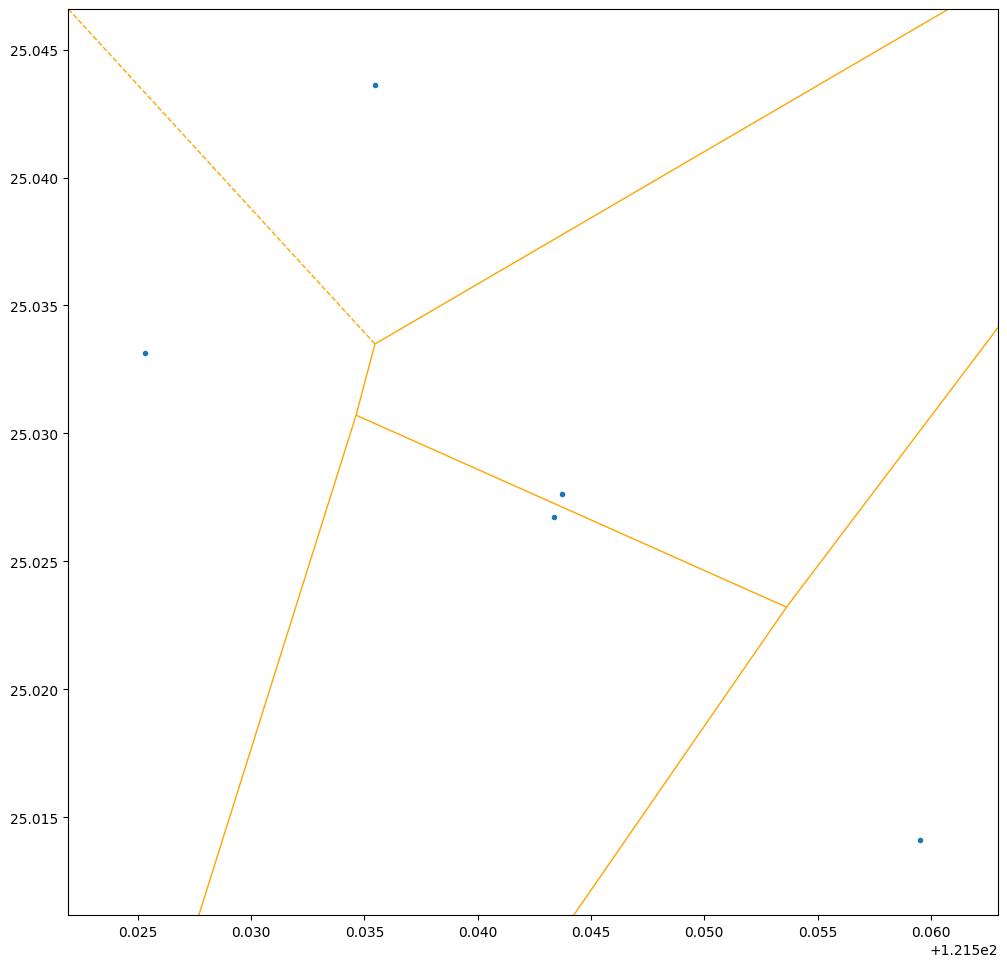

In [10]:
vor = Voronoi(coor_centroid.T[::-1].T)
fig_ops_district_vor = plot_voronoi_plot_2d(vor)
# plt.xlim(DEFAULT_GEO_ARGS['lng_bound'])
# plt.ylim(DEFAULT_GEO_ARGS['lat_bound'])
plt.savefig(str(Path(SAVE_DIR) / f'{TARGET_COUNTY}_{TARGET_TOWN}_voronoi.png'))
plt.show()

**Problems**

- finite fields to polygon
- infinite fields to finite state by boundary polygon
- boundary polygon may change the infinite polygon to multipolygon

In [11]:
# infinite voronoi polygon -> finite polygon
delimeter = np.array(boundary_geom.exterior.coords).ptp(axis=0)
delimeter = np.linalg.norm(delimeter)
print(f'Calc the proper delimeter - {delimeter}')

# get the mapping 
voronori_polygons = list(get_voronoi_polygon(vor, delimeter))
voronori_points = [Point(p) for p in vor.points]
df_geo = map_points_in_polygon(voronori_polygons, voronori_points)
print(f'Get the mapping geodataframe, shape={df_geo.shape}')

# validate the polygon after bounding
# valid_geo = (polygon, point)
valid_geo = get_bounded_polygon(df_geo.geometry_polygon, df_geo.geometry_point, boundary_geom)
valid_polygons, valid_points = list(zip(*valid_geo))

Calc the proper delimeter - 0.05814116792710677
Get the mapping geodataframe, shape=(5, 2)


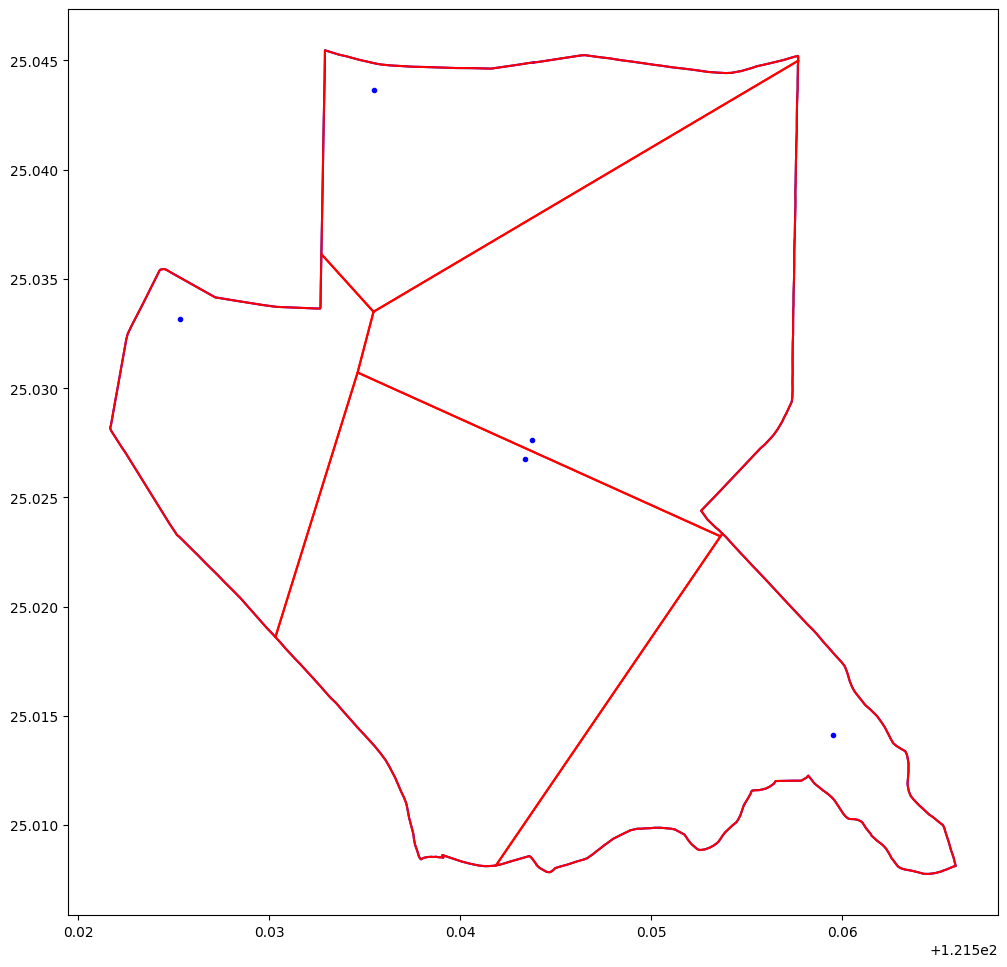

In [12]:
fig_vor_bound = plot_voronoi_with_bound(valid_polygons, valid_points, boundary_geom)
plt.savefig(str(Path(SAVE_DIR) / f'{TARGET_COUNTY}_{TARGET_TOWN}_final.png'))
plt.show()

## Output

In [13]:
df_geo_final = gpd.GeoDataFrame({
    'county': TARGET_COUNTY,
    'town': TARGET_TOWN,
    'geometry_polygon': valid_polygons,
    'geometry_point': valid_points
})
df_geo_final.set_geometry('geometry_polygon')
df_geo_final.set_geometry('geometry_point')
df_geo_final['polygon_id'] = df_geo_final.index
df_geo_final = df_geo_final[['polygon_id', 'county', 'town', 'geometry_polygon', 'geometry_point']]

display(df_geo_final.head())

,polygon_id,county,town,geometry_polygon,geometry_point
0,0,臺北市,大安區,"POLYGON ((121.5537316744534 25.02333577130574,...",POINT (121.5437354784811 25.02764010638585)
1,1,臺北市,大安區,"POLYGON ((121.5418789363044 25.00815751892905,...",POINT (121.5595407781413 25.01413220956363)
2,2,臺北市,大安區,"POLYGON ((121.5576963066342 25.04498726920236,...",POINT (121.5354705037597 25.04362989413114)
3,3,臺北市,大安區,"POLYGON ((121.535465122056 25.03349617366724, ...",POINT (121.5253372325927 25.03315240859758)
4,4,臺北市,大安區,"POLYGON ((121.5303298518306 25.01860603118048,...",POINT (121.5433809016743 25.0267419663321)
